<a href="https://colab.research.google.com/github/componavt/LLLE-R1900s/blob/main/src/visualization/credit_trends_by_settlement_and_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 Rural Credit Trends in Early 20th Century Russia (Bilingual)

This notebook visualizes **loan amount trends over time**, broken down by:
- **Settlements** (villages, volosts, etc.)
- **Credit types** (e.g., FarmBuildings, Livestock, Housing)

✨ **Features:**
- 🌍 Choose language: Russian (`ru`) or English (`en`)
- 🏘️ Settlement names: from `society_settlement.csv`
- 📊 Credit type labels: `loan_short_ru` (RU) or `Name` (EN) from `credit_items.csv`
- 🖼️ High-quality plots saved to `outputs/`

⚙️ Configure language via `USE_LANGUAGE` variable  
✅ Fully bilingual visualization

[2] 📦 Установка зависимостей

In [ ]:
# === CONFIGURATION ===
MIN_CREDIT_VISUAL = 3.0  # ← минимальная доля (в %), чтобы credit_item отображался за год
assert 0 <= MIN_CREDIT_VISUAL <= 100, "MIN_CREDIT_VISUAL must be between 0 and 100"


# Install required packages
!pip install -q python-dotenv pandas matplotlib

# Clone the repo if running in Colab (optional)
import os

if not os.path.exists('LLLE-R1900s'):
    !git clone https://github.com/componavt/LLLE-R1900s.git
    %cd LLLE-R1900s
else:
    %cd LLLE-R1900s

# === LANGUAGE SWITCH ===
USE_LANGUAGE = "ru"  # ← Change to "en" for English
assert USE_LANGUAGE in ("ru", "en"), "USE_LANGUAGE must be 'ru' or 'en'"

[3] 📥 Загрузка и подготовка данных

In [ ]:
import os
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Load config
load_dotenv('config.env')

# Paths
csv_out_dir = os.getenv('CSV_OUT_DIR', 'data/csv_out')
output_file_name = os.getenv('OUTPUT_CSV_FILE')

if not output_file_name:
    csv_files = [f for f in os.listdir(csv_out_dir) if f.endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError("No CSV files found in the output directory.")
    output_file_name = csv_files[0]

csv_path = os.path.join(csv_out_dir, output_file_name)
print(f"Loading loan data from: {csv_path}")

# Load main data
df_loans = pd.read_csv(csv_path)
print(f"Loaded {len(df_loans)} loan records.")

# Load reference data
df_credit = pd.read_csv('data/credit_items.csv')
df_society = pd.read_csv('data/society_settlement.csv')

# --- Settlement display names ---
if USE_LANGUAGE == "ru":
    df_society['display_settlement'] = df_society['Russian']
else:
    df_society['display_settlement'] = df_society['English']

settlement_name_map = dict(zip(df_society['English'], df_society['display_settlement']))

# Validate settlements
unknown_settlements = set(df_loans['settlement']) - set(df_society['English'])
if unknown_settlements:
    print("⚠️ Warning: Unknown settlements in loan data:", unknown_settlements)

# Add display names
df_loans['display_settlement'] = df_loans['settlement'].map(settlement_name_map)
df_loans = df_loans.dropna(subset=['display_settlement'])

# --- Credit item display labels ---
if USE_LANGUAGE == "ru":
    df_credit['display_label'] = df_credit['loan_short_ru']
else:
    df_credit['display_label'] = df_credit['Name']

credit_label_map = dict(zip(df_credit['Name'], df_credit['display_label']))

# Validate credit items
unknown_items = set(df_loans['credit_item']) - set(df_credit['Name'])
if unknown_items:
    print("⚠️ Warning: Unknown credit_item values:", unknown_items)

# --- Prepare time axis ---
df_loans['mid_month'] = ((df_loans['month_start'] + df_loans['month_end']) // 2).astype(int)
df_loans['date'] = pd.to_datetime(
    df_loans['year'].astype(str) + '-' + df_loans['mid_month'].astype(str) + '-01'
)

# Ensure output dir
os.makedirs('outputs', exist_ok=True)

print("✅ Data loaded and enriched with bilingual labels.")

Loading loan data from: data/csv_out/loans_s28_i21.csv
Loaded 1768 loan records.
✅ Data loaded and enriched with bilingual labels.


[4] 📈 Визуализация: Тренды по поселениям

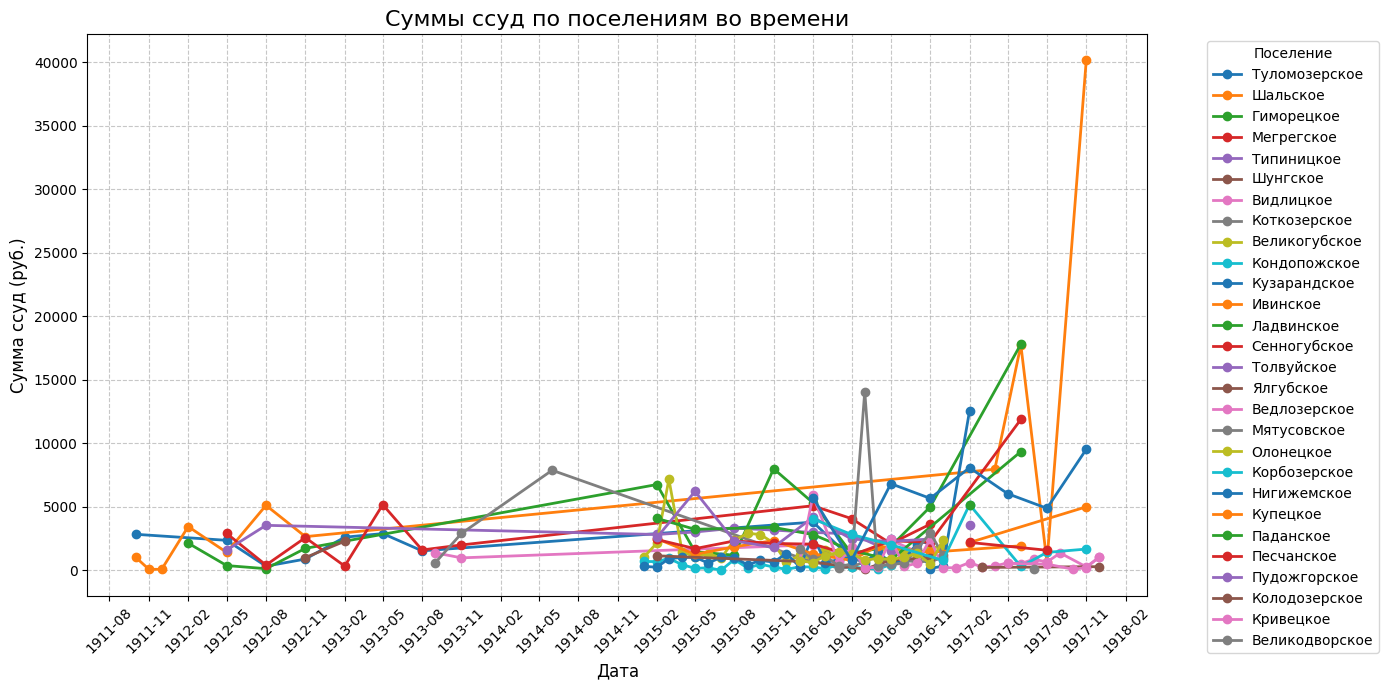

In [ ]:
# Aggregate by date and display settlement
grouped_by_settlement = df_loans.groupby(['date', 'display_settlement'])['amount_rubles'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 7))
for settlement in grouped_by_settlement['display_settlement'].unique():
    subset = grouped_by_settlement[grouped_by_settlement['display_settlement'] == settlement]
    plt.plot(subset['date'], subset['amount_rubles'], label=settlement, marker='o', linestyle='-', linewidth=2)

title = "Total Loan Amounts Over Time by Settlement" if USE_LANGUAGE == "en" else "Суммы ссуд по поселениям во времени"
xlabel = "Date" if USE_LANGUAGE == "en" else "Дата"
ylabel = "Total Loan Amount (Rubles)" if USE_LANGUAGE == "en" else "Сумма ссуд (руб.)"
legend_title = "Settlement" if USE_LANGUAGE == "en" else "Поселение"

plt.title(title, fontsize=16)
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/loans_by_settlement.png', dpi=150)
plt.show()

[5] 📊 Визуализация: Тренды по типам кредитов

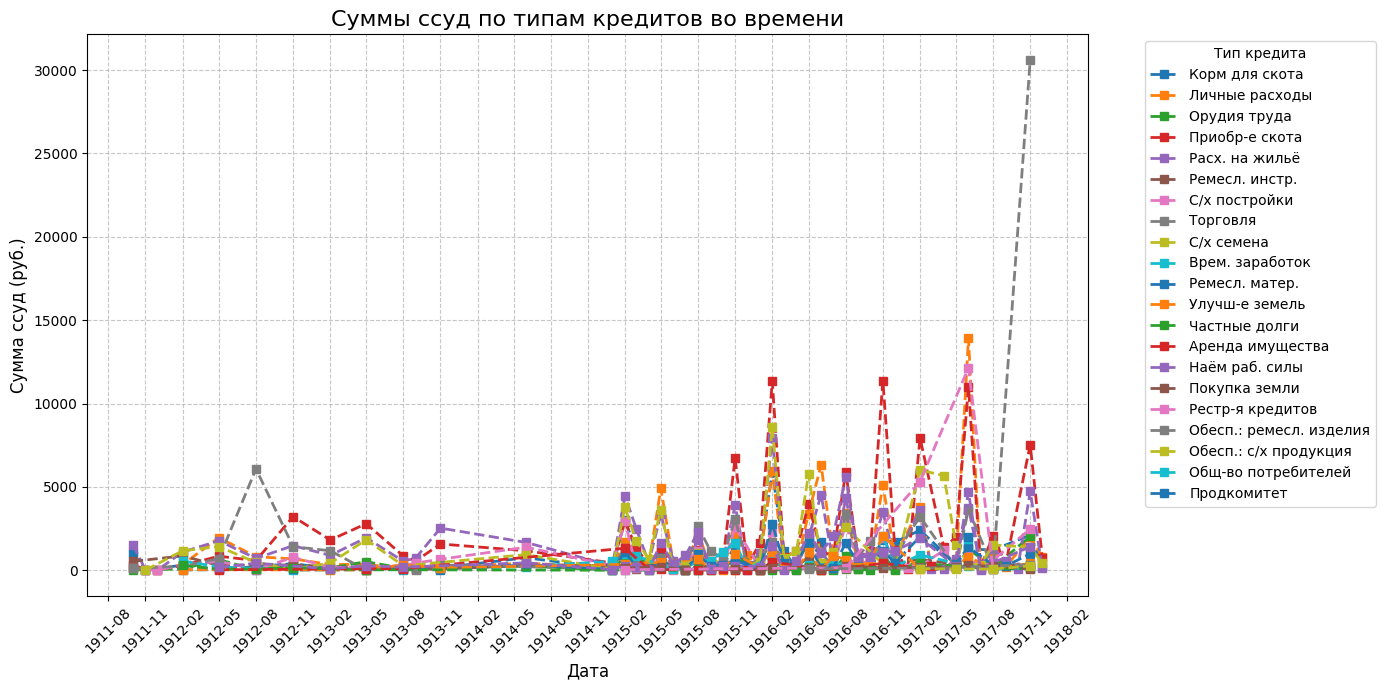

In [ ]:
# Map credit_item to display label
df_loans['display_credit'] = df_loans['credit_item'].map(credit_label_map)

# Aggregate by date and display credit type
grouped_by_credit = df_loans.groupby(['date', 'display_credit'])['amount_rubles'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 7))
for credit_type in grouped_by_credit['display_credit'].unique():
    subset = grouped_by_credit[grouped_by_credit['display_credit'] == credit_type]
    plt.plot(subset['date'], subset['amount_rubles'], label=credit_type, marker='s', linestyle='--', linewidth=2)

title = "Total Loan Amounts Over Time by Credit Type" if USE_LANGUAGE == "en" else "Суммы ссуд по типам кредитов во времени"
xlabel = "Date" if USE_LANGUAGE == "en" else "Дата"
ylabel = "Total Loan Amount (Rubles)" if USE_LANGUAGE == "en" else "Сумма ссуд (руб.)"
legend_title = "Credit Type" if USE_LANGUAGE == "en" else "Тип кредита"

plt.title(title, fontsize=16)
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/loans_by_credit_item.png', dpi=150)
plt.show()